In [ ]:
import pandas as pd
import tensorflow as tf

## LSTM with Attention

In [28]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abuinoschi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abuinoschi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
  
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  not word in stop_words]
    text = " ".join(text)
    return text

training_data = train_data
training_data['preprocessed_tweet_text'] = training_data.preprocessed_tweet_text.apply(lambda x: clean_text(x))
training_data.head()

,tweet_no,tweet_text,q1_label,q2_label,q3_label,q4_label,q5_label,q6_label,q7_label,language,tweet_link,tweet_link_count,preprocessed_tweet_text,emojis,translated_emojis,tweet_link_domain,tweet_link_path
0,1,For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results,0,unknown,unknown,unknown,unknown,no,no,en,[],0,average american best way tell covid19 cough rich person face wait test result,unknown,unknown,unknown,unknown
1,2,this is fucking bullshit,0,unknown,unknown,unknown,unknown,no,no,en,[],0,fuck bullshit,unknown,unknown,unknown,unknown
2,3,Can y’all please just follow the government’s instructions so we can knock this COVID-19 out and be done?! I feel like a kindergartner that keeps losing more recess time because one or two kids can’t follow directions.,0,unknown,unknown,unknown,unknown,no,no,en,[],0,yall please follow government instruction knock covid19 feel like kindergartner keep lose recess time one two kid cant follow direction,unknown,unknown,unknown,unknown
3,4,No offense but the corona virus disappearing before April actually sucks,0,unknown,unknown,unknown,unknown,no,no,en,[],0,offense corona virus disappear april actually suck,unknown,unknown,unknown,unknown
4,5,"This is the face of someone who just spent 9 hours in personal protective equipment moving critically ill Covid19 patients around London. I feel broken - and we are only at the start. I am begging people, please please do social distancing and self isolation #covid19 URL",1,no,yes,no,yes,no,no,en,[],0,face someone spend 9 hour personal protective equipment move critically ill covid19 patient around london feel break start beg people please please social distance self isolation covid19 url,unknown,unknown,unknown,unknown


In [30]:
validation_data['preprocessed_tweet_text'] = validation_data.preprocessed_tweet_text.apply(lambda x: clean_text(x))

In [31]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['preprocessed_tweet_text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_data['preprocessed_tweet_text'])
list_tokenized_valid = tokenizer.texts_to_sequences(validation_data['preprocessed_tweet_text'])

X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=30)
y_train = train_data['q1_label']

X_validation = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_valid, maxlen=30)
y_validation = validation_data['q1_label']

In [32]:
y_train.value_counts()

1    4428
0    1977
Name: q1_label, dtype: int64

In [33]:
weight_for_0 = (1 / 1977) * ((1977 + 4428) / 2.0)
weight_for_1 = (1 / 4428) * ((1977 + 4428) / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.6198786039453719, 1: 0.7232384823848238}

In [34]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [35]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [36]:
sequence_input = tf.keras.layers.Input(shape=(30,), dtype="int32")
embedding = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128)(sequence_input)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True), name="bi_lstm_0")(embedding)
(lstm, forward_h, forward_c, backward_h, backward_c) = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)
state_h  = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c =  tf.keras.layers.Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(32)(lstm, state_h)
dense1 = tf.keras.layers.Dense(16, activation="relu")(context_vector)
dropout = tf.keras.layers.Dropout(0.1)(dense1)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
model = tf.keras.Model(inputs=sequence_input, outputs=output)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
          optimizer=tf.keras.optimizers.Adam(1e-4),
          metrics=METRICS)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 128)      1280000     ['input_1[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 30, 256)      263168      ['embedding[0][0]']              
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 30, 128),    164352      ['bi_lstm_0[0][0]']              
                                 (None, 64),                                                  

In [38]:
history = model.fit(X_train,y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_validation, y_validation))

Epoch 1/10
51/51 [==============================] - 14s 157ms/step - loss: 0.6677 - tp: 4206.0000 - fp: 1869.0000 - tn: 108.0000 - fn: 222.0000 - accuracy: 0.6735 - precision: 0.6923 - recall: 0.9499 - auc: 0.4866 - prc: 0.6742 - val_loss: 0.7364 - val_tp: 947.0000 - val_fp: 828.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5335 - val_precision: 0.5335 - val_recall: 1.0000 - val_auc: 0.4743 - val_prc: 0.4961
Epoch 2/10
51/51 [==============================] - 7s 130ms/step - loss: 0.6239 - tp: 4428.0000 - fp: 1977.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.6913 - precision: 0.6913 - recall: 1.0000 - auc: 0.5066 - prc: 0.6816 - val_loss: 0.7143 - val_tp: 947.0000 - val_fp: 828.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5335 - val_precision: 0.5335 - val_recall: 1.0000 - val_auc: 0.7173 - val_prc: 0.7293
Epoch 3/10
51/51 [==============================] - 7s 131ms/step - loss: 0.5522 - tp: 4392.0000 - fp: 1786.0000 - tn: 191.0000 - fn: 3

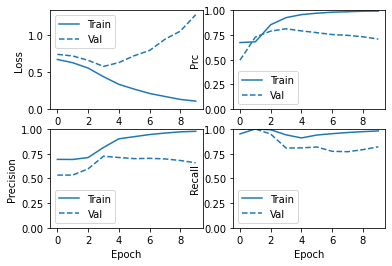

In [39]:
plt.figure(figsize=(16, 8))
plot_metrics(history)

In [40]:
weighted_history = model.fit(X_train,y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_validation, y_validation),
                   class_weight=class_weight)

Epoch 1/10
51/51 [==============================] - 10s 117ms/step - loss: 0.1208 - tp: 4293.0000 - fp: 79.0000 - tn: 1898.0000 - fn: 135.0000 - accuracy: 0.9666 - precision: 0.9819 - recall: 0.9695 - auc: 0.9881 - prc: 0.9936 - val_loss: 1.1573 - val_tp: 711.0000 - val_fp: 315.0000 - val_tn: 513.0000 - val_fn: 236.0000 - val_accuracy: 0.6896 - val_precision: 0.6930 - val_recall: 0.7508 - val_auc: 0.7325 - val_prc: 0.7193
Epoch 2/10
51/51 [==============================] - 6s 117ms/step - loss: 0.0851 - tp: 4334.0000 - fp: 51.0000 - tn: 1926.0000 - fn: 94.0000 - accuracy: 0.9774 - precision: 0.9884 - recall: 0.9788 - auc: 0.9919 - prc: 0.9956 - val_loss: 1.2607 - val_tp: 647.0000 - val_fp: 293.0000 - val_tn: 535.0000 - val_fn: 300.0000 - val_accuracy: 0.6659 - val_precision: 0.6883 - val_recall: 0.6832 - val_auc: 0.7268 - val_prc: 0.7189
Epoch 3/10
51/51 [==============================] - 6s 115ms/step - loss: 0.0818 - tp: 4323.0000 - fp: 45.0000 - tn: 1932.0000 - fn: 105.0000 - accura

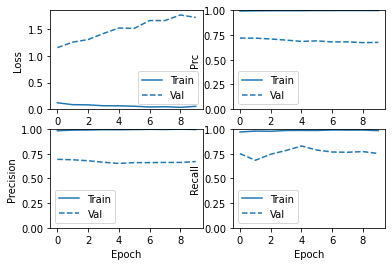

In [41]:
plot_metrics(weighted_history)